<a href="https://colab.research.google.com/github/Frosk-Kristian/COMP6002-Group10-Models/blob/main/COMP6002_Group_Project_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP6002 Computer Science Project - Group 10
Utilising Machine Learning to detect DDoS attacks.

## Reference
Iman Sharafaldin, Arash Habibi Lashkari, Saqib Hakak, and Ali A. Ghorbani, "Developing Realistic Distributed Denial of Service (DDoS) Attack Dataset and Taxonomy", IEEE 53rd International Carnahan Conference on Security Technology, Chennai, India, 2019.

# Setup
Run all of these first. Sets up libraries and directories used throughout notebook.

In [1]:
import pandas as pd
print(f"Using Pandas version: {pd.__version__}")

Using Pandas version: 2.0.3


In [2]:
import numpy as np
print(f"Using Numpy version: {np.__version__}")

Using Numpy version: 1.25.2


In [3]:
from sklearn import __version__ as skl_ver
print(f"Using Sklearn version: {skl_ver}")

Using Sklearn version: 1.2.2


In [5]:
!pip install codecarbon

from codecarbon import __version__ as cc_ver
print(f"Using CodeCarbon.io version: {cc_ver}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.9 MB/s eta 0:00:00
Using CodeCarbon.io version: 2.4.2


In [6]:
import os
from google.colab import drive

# mounts google drive
drive.mount("/content/drive")

# directory that project related files are stored in
dl_dir = os.getcwd() + r'/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data'
# directory that exports are saved in
#save_dir = dl_dir + f"/Exports_{pd.Timestamp.today(tz='Australia/Perth').strftime('%d-%m-%Y')}"
save_dir = dl_dir + f"/Exports_21-05-2024"
# directory that the runtime will store the unzipped dataset in (not on your drive)
data_dir = os.getcwd() + '/dataset'

# checks if export directory already exists, if not creates it
if os.path.exists(dl_dir):
  print(f"Directory {dl_dir} already exists.\n")
else:
  os.mkdir(dl_dir)
  print(f"Successfully created the directory {dl_dir}")

# checks if saves directory already exists, if not creates it
if os.path.exists(save_dir):
  print(f"Directory {save_dir} already exists.\n")
else:
  os.mkdir(save_dir)
  print(f"Successfully created the directory {save_dir}")

Mounted at /content/drive
Directory /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data already exists.

Directory /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024 already exists.



## Instance Details
Gets hardware specifications and region details of the Google Colab instance.

In [ ]:
# CPU specifications
from psutil import *

!cat /proc/cpuinfo | grep "model name" | head -1

print(f"Number of CPU: {cpu_count()}")
!cat /proc/cpuinfo

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Number of CPU: 2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi

In [ ]:
# VRAM specifications
virtual_memory()

svmem(total=13609435136, available=12289888256, percent=9.7, used=1007325184, free=8147763200, active=687906816, inactive=4511879168, buffers=352116736, cached=4102230016, shared=2277376, slab=164962304)

In [ ]:
# GPU specifications
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Server information
!curl ipinfo.io

{
  "ip": "34.74.119.44",
  "hostname": "44.119.74.34.bc.googleusercontent.com",
  "city": "North Charleston",
  "region": "South Carolina",
  "country": "US",
  "loc": "32.8546,-79.9748",
  "org": "AS396982 Google LLC",
  "postal": "29415",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}

## Define Helper Functions

In [7]:
# helper functions for exporting/importing models trained with Sklearn
# all functions defined will prompt the user for confirmation unless skip_prompt is True, to allow for skipping the functions when running the notebook
import joblib

print(f"Using Joblib version: {joblib.__version__}")

# function used to append a number to a filename in the event that the file already exists
def IncrementFname(file_path):
  """
  Takes a file path, splits the file name/extension and inserts an incrementing integer between them until a unique name is found.

  Parameters:
    file_path (string): full file path to increment, including extension.
  Returns:
    string: new file name in the form of 'path/to/file(i).extension'.
  """
  fname, ext = os.path.splitext(file_path)
  i = 1
  new_name = f'{fname}({i}){ext}' # intial reassignment

  # if filename(1).extension already exists, increment number until an unused one is found
  while os.path.exists(new_name):
    i += 1
    new_name = f'{fname}({i}){ext}'

  return new_name

# Save a trained model to the provided filepath
def SaveToFile(save_data, save_fpath, skip_prompt: bool = False, to_compress: bool = False):
  """
  Exports a object to a provided path using joblib, with or without prompting user for confirmation.

  Parameters:
    save_data (object): object to be saved.
    save_fpath (string): file path that the object will be saved in, including filename and extension.
    skip_prompt (boolean): if True, skips prompting user for confirmation before saving.
  Returns:
    : no value returned.
  """
  to_save = "y" if skip_prompt else ""

  # loops until 'y', 'Y', 'n', or 'N' have been entered by the user, returns early if 'n' or 'N' are entered.
  while to_save.lower() not in ('y', 'n'):
    to_save = input("Export to file? (y/n)\n")
    if to_save.lower() in 'y':
      print("Save confirmed.")
    elif to_save.lower() in 'n':
      print("Save cancelled.")
      return
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  fpath = save_fpath # allows for reassignment
  if os.path.isfile(fpath):
    print(f"WARNING: file \'{fpath}\' already exists...")
    fpath = IncrementFname(fpath)
    print(f"...Saving to \'{fpath}\' instead.")

  try:
    if to_compress:
      joblib.dump(save_data, fpath, compress=3)
    else:
      joblib.dump(save_data, fpath)
  except:
    print(f"ERROR: an unknown error occured calling \'joblib.dump({save_data}, {fpath})\'!")
  else:
    print(f"SUCCESS: saved to \'{fpath}\'.")


# Load a trained model from the provided filepath
def LoadFromFile(load_fpath, skip_prompt = False):
  """
  Import a serialised object via joblib.

  Parameters:
    load_fpath (string): file path to stored object.
    skip_prompt (boolean): if True, skips prompting user for confirmation before loading.
  Returns:
    object: if a file is found and loaded correctly, returns the stored object.
    None: if a user enters 'n' to cancel, no matching file is found or an error occurs during loading, returns None.
  """
  to_load = "y" if skip_prompt else ""

  # loops until 'y', 'Y', 'n', or 'N' have been entered by the user, returns early if 'n' or 'N' are entered.
  while to_load.lower() not in ('y', 'n'):
    to_load = input("Do you wish to import from file? {y/n)\n")
    if to_load.lower() in 'y':
      print("Load confirmed.")
    elif to_load.lower() in 'n':
      print("Load cancelled.")
      return None
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  load_data = None
  print(f"Attempting to load object from \'{load_fpath}\'...")
  try:
    load_data = joblib.load(load_fpath)
  except FileNotFoundError:
    print(f"ERROR: the file \'{load_fpath}\' does not exist!")
    return None
  except:
    print(f"ERROR: an unknown error occurred calling \'joblib.load{load_fpath}\'!")
    return None
  else:
    print(f"SUCCESS: loaded data from \'{load_fpath}\'.")

  return load_data


Using Joblib version: 1.4.2


# Import Data
Checks current working directory for datasets, if datasets are missing downloads a [.zip archive mirror of the CiCDDoS2019 hosted on Kaggle](https://www.kaggle.com/datasets/kristianfrossos/cicddos2019/data).

**NOTE:** the first part of this section is specific to Google Colab, and will not work outside of it. Advise writing an alternative later for local use (relevant when training Neural Network for speed and when usage limits get in the way).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# sets up kaggle environment variables (needed to access API)
from google.colab import userdata
from google.colab import files

# checks if kaggle key and username have been provided as secrets and sets environment variables appropriately
# if not found, attempts to use kaggle.json
try:
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
  print("Using KAGGLE_KEY and KAGGLE_USERNAME defined in secrets.")
except (userdata.SecretNotFoundError, userdata.NotebookAccessError):
  print("WARN: One or more secret(s) missing or inaccessible.\n")
  if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Using existing kaggle.json")
  else:
    print("Please upload kaggle.json")
    files.upload()

    if os.path.isfile(os.getcwd() + '/content/kaggle.json'):
      !rm -r ~/.kaggle
      !mkdir ~/.kaggle
      !mv ./kaggle.json ~/.kaggle/
      !chmod 600 ~/.kaggle/kaggle.json
    else:
      print("\'kaggle.json\' not uploaded.")
      raise

Using KAGGLE_KEY and KAGGLE_USERNAME defined in secrets.


In [ ]:
# checks if .zip archive containing dataset already exists in google drive and downloads it if necessary
if os.path.isfile(dl_dir + '/cicddos2019.zip'):
  print("Dataset already present.")
else:
  print(f"Downloading zipped dataset to {dl_dir}")
  !kaggle datasets download kristianfrossos/cicddos2019 -p {dl_dir.replace(' ', '\ ')}

# creates the content/dataset directory if it doesn't already exist
if os.path.exists(data_dir):
  print(f"Directory {data_dir} already exists.")
else:
  print(f"Created directory: {data_dir}")
  os.mkdir(data_dir)

# extracts contents of .zip archive to content/dataset if directory is not empty
if not os.listdir(data_dir):
  print("Empty directory, extracting dataset.")
  # unzips .zip archive
  !unzip {dl_dir.replace(' ', '\ ') + '/cicddos2019.zip'} -d {data_dir}
else:
  print("Non-empty directory, skipping download")

Dataset already present.
Created directory: /content/dataset
Empty directory, extracting dataset.
Archive:  /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/cicddos2019.zip
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_NetBIOS.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/Syn.csv  
  inflating: /content/dataset/CSV-01-12/01-12/TFTP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/UDPLag.csv  
  inflating: /content/dataset/CSV-03-11/03-11/LDAP.csv  
  inflating: /content/dataset/CSV-03-11/03-11/MSSQL.csv  
  inflating: /content/d

In [ ]:
# initialises empty list
csv_list = []

# iterates through all subdirectories of /content/dataset and appends the filepath of each .csv to csv_list
for root, dirs, files in os.walk(data_dir):
  for f in files:
    if f.endswith(".csv"):
      csv_list.append(os.path.join(root, f))

# if .csv files were found, displays number of files and prints each path
if not csv_list:
  print("No .csv files found!")
else:
  print(f"{len(csv_list)} .csv files found.")
  for csv in csv_list:
    print(csv)

18 .csv files found.
/content/dataset/CSV-03-11/03-11/UDP.csv
/content/dataset/CSV-03-11/03-11/NetBIOS.csv
/content/dataset/CSV-03-11/03-11/UDPLag.csv
/content/dataset/CSV-03-11/03-11/MSSQL.csv
/content/dataset/CSV-03-11/03-11/Syn.csv
/content/dataset/CSV-03-11/03-11/LDAP.csv
/content/dataset/CSV-03-11/03-11/Portmap.csv
/content/dataset/CSV-01-12/01-12/UDPLag.csv
/content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv
/content/dataset/CSV-01-12/01-12/Syn.csv
/content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv
/content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv
/content/dataset/CSV-01-12/01-12/TFTP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_NetBIOS.csv


## Samples Dataset and Creates Subset

In [ ]:
ddos_df = pd.DataFrame()
benign_df = pd.DataFrame()

for csv in csv_list:
  data_iter = pd.read_csv(csv, chunksize=5000)
  print(f"Reading {csv}...")

  for chunk in data_iter:
    ddos_rows = chunk[chunk[' Label'].str.lower() != 'benign']
    benign_rows = chunk[chunk[' Label'].str.lower() == 'benign']

    sample_size = min(len(ddos_rows), len(benign_rows)) // 25
    ddos_sample = ddos_rows.sample(n=sample_size, random_state=42)
    benign_sample = benign_rows.sample(n=sample_size, random_state=42)

    ddos_df = pd.concat([ddos_df, ddos_sample], ignore_index=True)
    benign_df = pd.concat([benign_df, benign_sample], ignore_index=True)

Reading /content/dataset/CSV-03-11/03-11/UDP.csv...
Reading /content/dataset/CSV-03-11/03-11/NetBIOS.csv...
Reading /content/dataset/CSV-03-11/03-11/UDPLag.csv...
Reading /content/dataset/CSV-03-11/03-11/MSSQL.csv...
Reading /content/dataset/CSV-03-11/03-11/Syn.csv...
Reading /content/dataset/CSV-03-11/03-11/LDAP.csv...
Reading /content/dataset/CSV-03-11/03-11/Portmap.csv...
Reading /content/dataset/CSV-01-12/01-12/UDPLag.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv...
Reading /content/dataset/CSV-01-12/01-12/Syn.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv...
Reading /content/dataset/CSV-01-12/01-12/TFTP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_NetB

In [ ]:
# concatenates ddos and benign dataframes into one subset
subset = pd.concat([ddos_df, benign_df], ignore_index=True)

# class weights
weights = subset.value_counts(' Label', normalize=True)
counts = subset.value_counts(' Label')

# prints classes and their weights
print("     Class      |     Weight     |     Count")
for index in weights.index:
  print(f'{index:<15} | {(weights[index] * 100.0):<14n} | {counts[index]:n}')

# prints total (for error checking)
print(f"{'Total':<15} | {sum(weights.values) * 100.0:<14n} | {sum(counts.values)}")

# stores unprocessed subset
subset.to_csv((dl_dir + '/COMP6002_Raw_Subset.csv'), index = False)

     Class      |     Weight     |     Count
BENIGN          | 50             | 1960
Syn             | 12.9082        | 506
TFTP            | 10.7653        | 422
DrDoS_NTP       | 4.56633        | 179
UDP-lag         | 3.59694        | 141
UDP             | 2.37245        | 93
DrDoS_DNS       | 2.37245        | 93
Portmap         | 2.32143        | 91
NetBIOS         | 2.16837        | 85
MSSQL           | 1.83673        | 72
LDAP            | 1.45408        | 57
DrDoS_UDP       | 1.30102        | 51
DrDoS_MSSQL     | 1.07143        | 42
UDPLag          | 1.04592        | 41
DrDoS_NetBIOS   | 0.739796       | 29
DrDoS_SNMP      | 0.663265       | 26
DrDoS_LDAP      | 0.433673       | 17
DrDoS_SSDP      | 0.280612       | 11
WebDDoS         | 0.102041       | 4
Total           | 100            | 3920


# Data Preprocessing
## Dropped Features
*   Unnamed: 0: unknown feature.
*   Flow Id: constructed from Source Ip, Destination Ip, Source Port, Destination Port and Protocol.
*   Similar HTTP: object with no meaningful way to encode (the exact same objects won't necessarily exist in real data)
*   Fwd Packet Length Mean: deemed non-useful.
*   Fwd Header Length.1: duplicate of existing column.
*   UnixTimestamp: suspected to cause overfitting.

In [ ]:
from sklearn.model_selection import train_test_split
import ipaddress

subset_path = dl_dir + '/COMP6002_Processed_Subset.csv'

In [ ]:
# optionally import a unprocessed subset, skips above steps.
raw_load = ""

while raw_load.lower() not in ('y', 'n'):
  raw_load = input("Do you wish to load a previously generated (but not processed) subset? (y/n)\n")

  if raw_load.lower() in ('y'):
    raw_path = dl_dir + '/COMP6002_Raw_Subset.csv'
    try:
      subset = pd.read_csv(raw_path)
      print(f"\'{raw_path}\' loaded successfully.")
    except:
      print(f"ERROR: an unknown error occured loading \'{raw_path}\'!")
  else:
    if raw_load.lower() in ('n'):
      print("Did not attempt to load existing data.")
    else:
      print("WARNING: please only input \'y\' to load the data or \'n\' to skip loading.")

del raw_load

Do you wish to load a previously generated (but not processed) subset? (y/n)
y
'/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Raw_Subset.csv' loaded successfully.


In [ ]:
# replace infinite values with NaN so they are caught by the next 2 steps
subset.replace([np.inf, -np.inf], np.nan, inplace = True)

# drop columns with at least 50% missing values
subset.dropna(axis = 1,
              thresh = int(0.5 * subset.shape[0]),
              inplace = True)

# replace missing values with the mean of their columns
for col in subset.columns:
  if subset[col].isna().sum() > 0:
    subset[col].fillna(subset[col].mean(), inplace = True)

# drop duplicate rows
subset.drop_duplicates(inplace = True)

# converts source and destination IP addresses to useable integer values
subset['Source IP_int'] = subset.apply(lambda x: int (ipaddress.IPv4Address(x[' Source IP'])), axis=1)
subset['Destination IP_int'] = subset.apply(lambda x: int (ipaddress.IPv4Address(x[' Destination IP'])), axis=1)

# converts date and time values to unix timestamps
subset['UnixTimestamp'] = subset.apply(lambda x: (pd.to_datetime(x[' Timestamp']).timestamp()), axis=1)

subset['IsDDoS'] = (subset[' Label'].str.lower() != 'benign')

# drops original columns
subset.drop(columns = [' Source IP', ' Destination IP', ' Timestamp', ' Label'], inplace = True)

# drops irrelevant columns
subset.drop(columns = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP', ' Fwd Packet Length Mean', ' Fwd Header Length.1', 'UnixTimestamp'], inplace = True)

## Save Processed Data

In [ ]:
# optionally save processed subset to .csv
subset_save = ""

while subset_save.lower() not in ('y', 'n'):
  subset_save = input("Do you wish to export the subset to a .csv? (y/n)")

  if subset_save.lower() in ('y'):
    new_subset_path = subset_path

    if os.path.exists(new_subset_path):
      new_subset_path = IncrementFname(subset_path)

    try:
      subset.to_csv(new_subset_path, index = False)
      print(f"Subset saved as \'{new_subset_path}\'.")
    except:
      print(f"ERROR: an unknown error occured saving \'{new_subset_path}\'!")
  else:
    if subset_save.lower() in ('n'):
      print("Skipped exporting to .csv file.")
    else:
      print("WARNING: please only input \'y\' to save the data to a .csv or \'n\' to skip saving.")

del subset_save

Do you wish to export the subset to a .csv? (y/n)y
Subset saved as '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Processed_Subset.csv'.


## Load Previously Processed Data

In [ ]:
# optionally import a preprocessed subset, skips above steps.
subset_load = ""

while subset_load.lower() not in ('y', 'n'):
  subset_load = input("Do you wish to load a previously preprocessed subset? (y/n)\n")

  if subset_load.lower() in ('y'):
    subset_path = dl_dir + '/COMP6002_Processed_Subset.csv'
    try:
      subset = pd.read_csv(subset_path)
      print(f"\'{subset_path}\' loaded successfully.")
    except:
      print(f"ERROR: an unknown error occured loading \'{subset_path}\'!")
  else:
    if subset_load.lower() in ('n'):
      print("Did not attempt to load existing data.")
    else:
      print("WARNING: please only input \'y\' to load the data or \'n\' to skip loading.")

del subset_load

Do you wish to load a previously preprocessed subset? (y/n)
y
'/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Processed_Subset.csv' loaded successfully.


## Split Training/Testing Data

In [ ]:
# splits subset across x and y axis
X = subset.drop(columns = ['IsDDoS', 'Source IP_int', 'Destination IP_int'], inplace = False)
y = subset['IsDDoS']

In [ ]:
# set aside 20% of data to be used in testing, keeping the remaining 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## Normalise Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# exports scaler for future use
SaveToFile(save_data = scaler, save_fpath = (save_dir + '/std_scaler.joblib'), skip_prompt = True)

...Saving to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/std_scaler(1).joblib' instead.
SUCCESS: saved to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/std_scaler(1).joblib'.


## Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# "base" random forest model used for feature selection, so as to not require the actual rf we're using to be trained when attempting to train the neural network
base_rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
selector = SelectFromModel(estimator = base_rf).fit(X_train, y_train)

selector.set_output(transform="pandas")

# keeps only the features identified by selector
#X_train_new = X_train_res[selector.get_feature_names_out()]
X_train_new = selector.transform(X_train)
#X_test_new = X_test[selector.get_feature_names_out()]
X_test_new = selector.transform(X_test)

# list selected features
print(f"Features remaining: {X_train_new.shape[1]}")
for col in X_train_new.columns:
  print(f"{col}")

#del base_rf

Features remaining: 25
 Source Port
 Destination Port
Total Length of Fwd Packets
 Total Length of Bwd Packets
 Fwd Packet Length Max
 Fwd Packet Length Min
Bwd Packet Length Max
Flow Bytes/s
 Flow IAT Mean
 Flow IAT Max
 Bwd Header Length
 Bwd Packets/s
 Min Packet Length
 Max Packet Length
 Packet Length Mean
 Packet Length Std
 Packet Length Variance
 ACK Flag Count
 URG Flag Count
 Average Packet Size
 Avg Fwd Segment Size
 Subflow Fwd Bytes
Init_Win_bytes_forward
 Init_Win_bytes_backward
 Inbound


### Feature Importance

In [ ]:
from matplotlib import pyplot as plt

std = np.std([tree.feature_importances_ for tree in selector.estimator_.estimators_], axis=0)
rf_importances = pd.Series(selector.estimator_.feature_importances_, index=X_train.columns)

#### Mean Decrease in Impurity

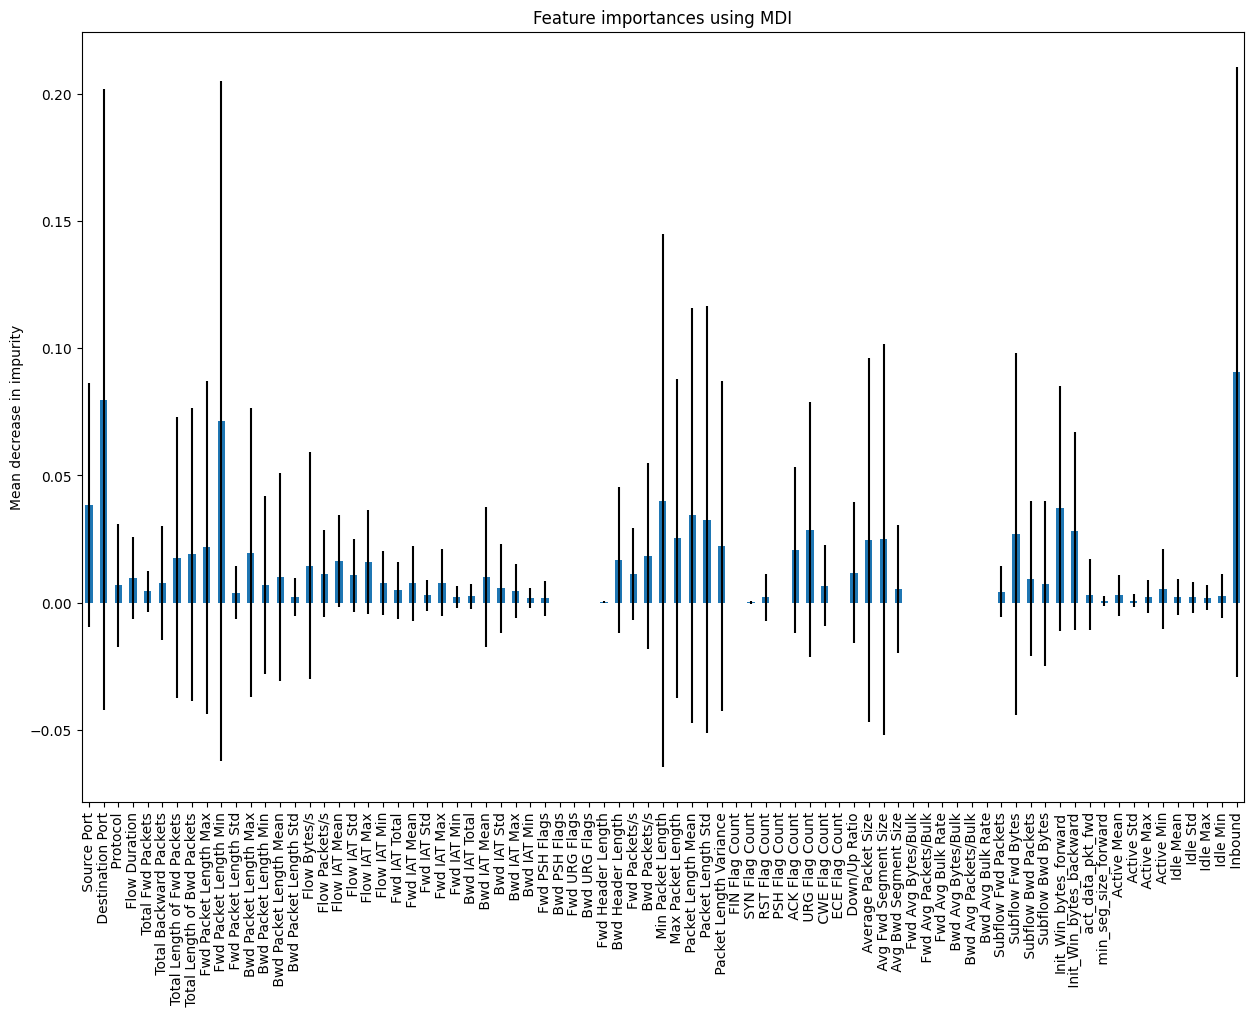

In [ ]:
# plot feature importance (mean decrease in impurity)
fig, ax = plt.subplots(figsize=(15,10))
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

#### Permutation

In [ ]:
from sklearn.inspection import permutation_importance

pi_result = permutation_importance(selector.estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

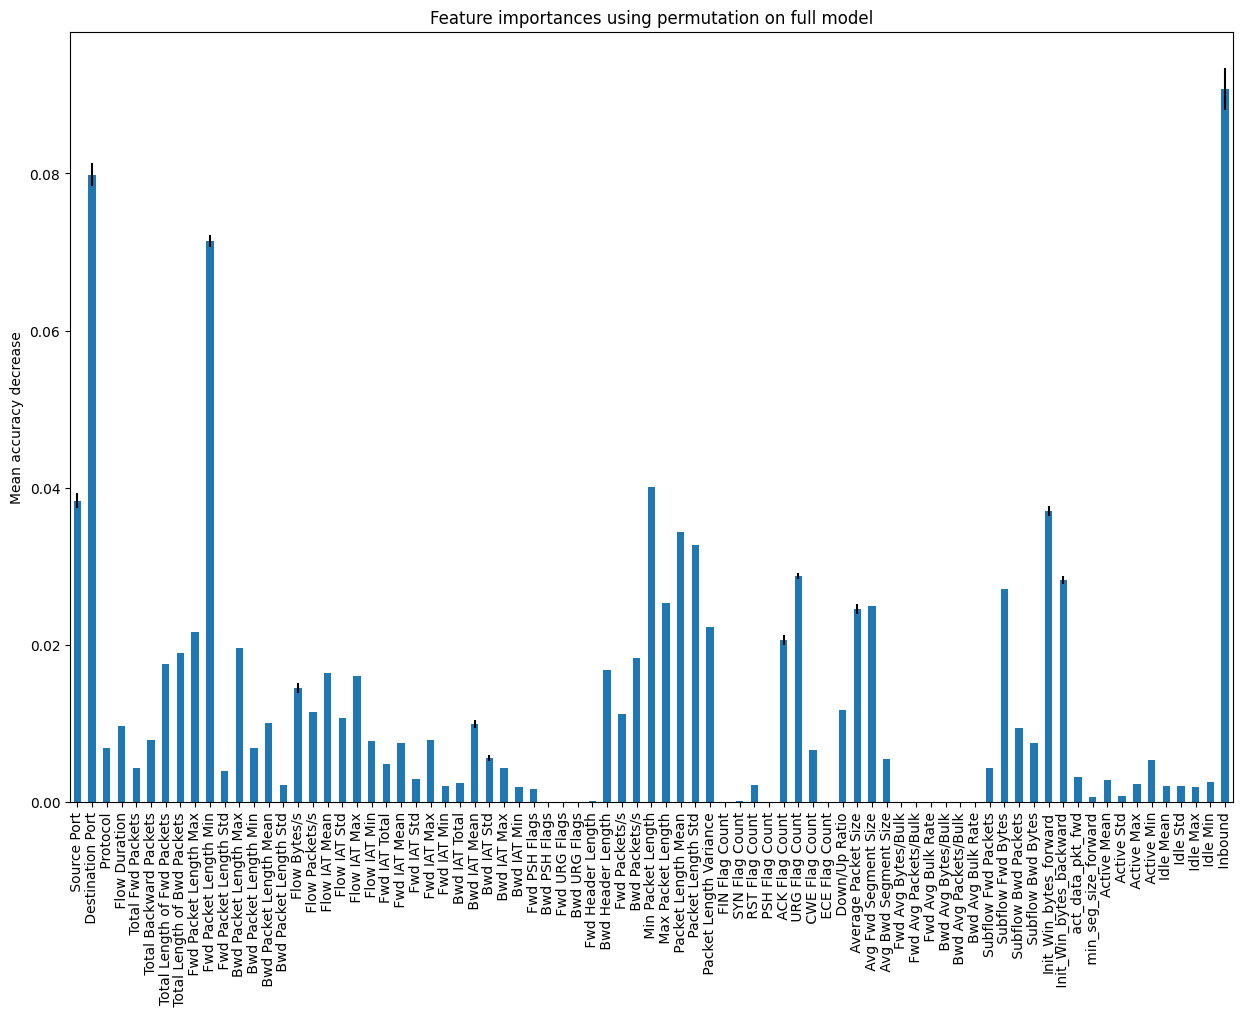

In [ ]:
# plot feature importance (permutation)
fig, ax = plt.subplots(figsize=(15,10))
rf_importances.plot.bar(yerr=pi_result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

## Save Training/Testing Data

In [ ]:
X_train_new.to_csv((save_dir + '/x.csv'), index = False)
y_train.to_csv((save_dir + '/y.csv'), index = False)

In [ ]:
X_test_new.to_csv((save_dir + '/x_test.csv'), index = False)
y_test.to_csv((save_dir + '/y_test.csv'), index = False)

# Build Models

In [ ]:
# imports needed for both models
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV

In [ ]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(project_name = "detect_ddos_with_ml")

[codecarbon WARNING @ 11:25:14] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 11:25:14] [setup] RAM Tracking...
[codecarbon INFO @ 11:25:14] [setup] GPU Tracking...
[codecarbon INFO @ 11:25:14] No GPU found.
[codecarbon INFO @ 11:25:14] [setup] CPU Tracking...
[codecarbon WARNING @ 11:25:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:25:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 11:25:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 11:25:15] >>> Tracker's metadata:
[codecarbon INFO @ 11:25:15]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 11:25:15]   Python version: 3.10.12
[codecarbon INFO @ 11:25:15]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 11:25:15]   Available RAM : 12.675 GB
[codecarbon INFO @ 11:25:15]   CPU count: 2
[codecarbon INFO @ 11:25:15]   CP

## Random Forest
**Values removed from param grid:**
*   n_estimators:
   *   100 - overfitting.
*   max_depth:
   *   None - overfitting.
   *   20 - overfitting.
   *   10 - overfitting.
*   max_features:
   *   'sqrt' - overfitting.
   *   'log2' - overfitting.

**Observations/Notes:**
*   Most of the above points are outdated, started hyperparameter tuning again after changing features due to poor accuracy on testing datasets.

In [ ]:
# build random forest classifier model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 42)

# grid of parameters to search through when performing cross validation
rf_params = {
    'n_estimators' : [200, 500],
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['sqrt', 0.3]
}

# tests all permutations of the parameters outline in rf_params, returns the best performing model
rf_model = GridSearchCV(estimator = rf,
                        param_grid = rf_params,
                        scoring = ["accuracy", "f1_weighted", "precision_weighted"],
                        refit = "f1_weighted",
                        cv = 5,
                        verbose = 3,
                        return_train_score = True,
                        n_jobs = 1)

### Train Random Forest

In [ ]:
tracker.start_task("train rf")

try:
  # train model
  rf_model.fit(X_train_new, y_train)
finally:
  rf_emissions = tracker.stop_task("train rf")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=200; accuracy: (train=1.000, test=0.994) f1_weighted: (train=1.000, test=0.994) precision_weighted: (train=1.000, test=0.994) total time=   0.8s
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=200; accuracy: (train=1.000, test=0.998) f1_weighted: (train=1.000, test=0.998) precision_weighted: (train=1.000, test=0.998) total time=   0.8s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=200; accuracy: (train=1.000, test=1.000) f1_weighted: (train=1.000, test=1.000) precision_weighted: (train=1.000, test=1.000) total time=   0.8s
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=200; accuracy: (train=1.000, test=0.995) f1_weighted: (train=1.000, test=0.995) precision_weighted: (train=1.000, test=0.995) total time=   0.8s
[CV 5/5] END criterion=gini, max_features=sqrt, n_estimators=200; accuracy: (train=1.000, test=0.997) f1_weighted: (

[codecarbon WARNING @ 11:26:38] Background scheduler didn't run for a long period (82s), results might be inaccurate
[codecarbon INFO @ 11:26:38] Energy consumed for RAM : 0.000109 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 11:26:38] Energy consumed for all CPUs : 0.000977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:26:38] 0.001086 kWh of electricity used since the beginning.


In [ ]:
print(f'Emissions: {rf_emissions.emissions * 1_000} g CO₂')

Emissions: 0.3100143941134465 g CO₂


In [ ]:
# training results
rf_train = rf_model.predict(X_train_new)

# displays the best model produced in training as well as its' hyperparameters and f1 score
print(f'Training Result:\n Best Model: {rf_model.best_estimator_}\n Best Parameters: {rf_model.best_params_}\n F1 Score: {rf_model.best_score_}')

# evaluate the models performance and display scores
print(f'Random Forest (TRAINING):\n accuracy: {accuracy_score(y_train, rf_train):f}\n f1 score: {f1_score(y_train, rf_train, average="weighted"):f}\n precision: {precision_score(y_train, rf_train, average="weighted")}')

Training Result:
 Best Model: RandomForestClassifier(class_weight='balanced', max_features=0.3,
                       n_estimators=500, n_jobs=-1, random_state=42)
 Best Parameters: {'criterion': 'gini', 'max_features': 0.3, 'n_estimators': 500}
 F1 Score: 0.9977635644148585
Random Forest (TRAINING):
 accuracy: 1.000000
 f1 score: 1.000000
 precision: 1.0


### Test Random Forest

In [ ]:
# make predictions on test data
rf_test = rf_model.predict(X_test_new)

# evaluate the models performance and display scores
print(f'Random Forest (TESTING):\n accuracy: {accuracy_score(y_test, rf_test):f}\n f1 score: {f1_score(y_test, rf_test, average="weighted"):f}\n precision: {precision_score(y_test, rf_test, average="weighted")}')

Random Forest (TESTING):
 accuracy: 1.000000
 f1 score: 1.000000
 precision: 1.0


### Export Model

In [ ]:
# uses joblib to serialise trained random forest model
SaveToFile(save_data = rf_model, save_fpath = (save_dir + "/random_forest.joblib"), skip_prompt = True, to_compress = True)

SUCCESS: saved to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/random_forest.joblib'.


# Explain Random Forest

In [10]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


In [13]:
import shap
print(f"Using Shap version: {shap.__version__}")

Using Shap version: 0.45.1


## Load Variables
When working across multiple runtimes.

In [8]:
# load in previously saved training/testing data
X_train_new = pd.read_csv((save_dir + '/x.csv'))#, dtype = np.float64)
#y_train_res = pd.read_csv((save_dir + '/y.csv'))
X_test_new = pd.read_csv((save_dir + '/x_test.csv'))

In [9]:
rf_model = LoadFromFile(load_fpath = (save_dir + "/random_forest.joblib"))

Do you wish to import from file? {y/n)
y
Load confirmed.
Attempting to load object from '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/random_forest.joblib'...
SUCCESS: loaded data from '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/random_forest.joblib'.


## Compute Shap Values

In [14]:
explainer = shap.Explainer(rf_model.predict_proba, X_train_new)
explanation = explainer(X_test_new)

PermutationExplainer explainer: 784it [31:27,  2.42s/it]


In [15]:
SaveToFile(save_data=explanation, save_fpath = f"{save_dir}/explanation.joblib", skip_prompt = True)

SUCCESS: saved to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_21-05-2024/explanation.joblib'.


### Feature Effect Plot

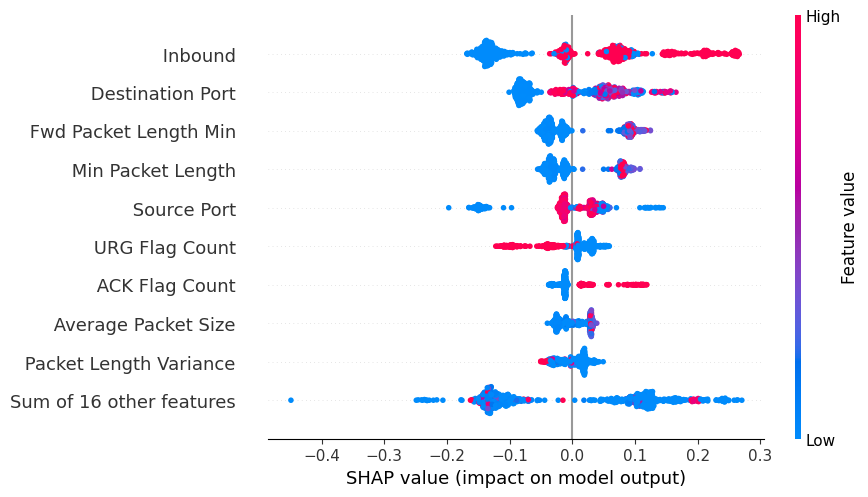

In [18]:
shap.plots.beeswarm(explanation[:,:,1])

### Feature Importance Plot

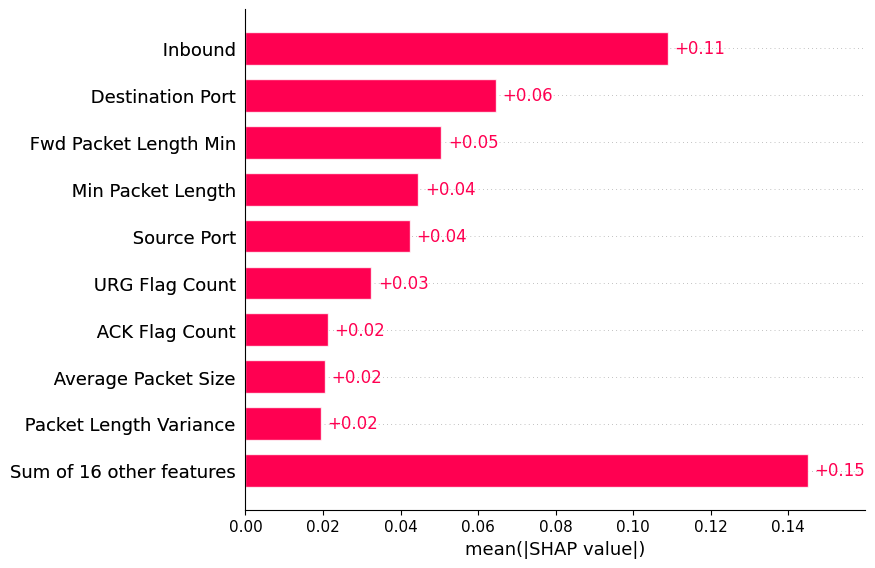

In [25]:
shap.plots.bar(explanation[:,:,1])

### Feature Interaction Plots

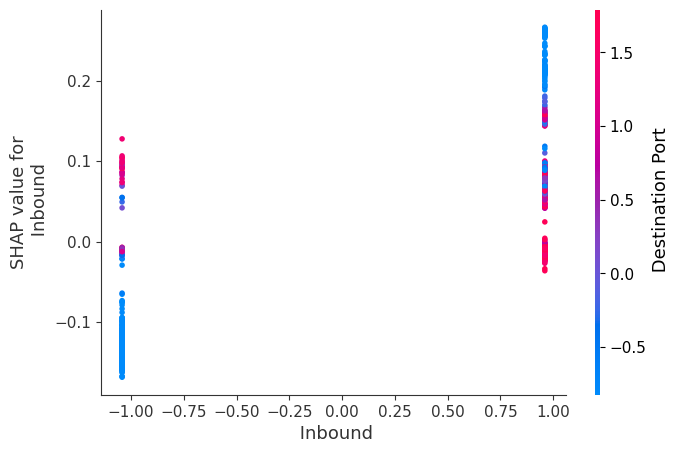

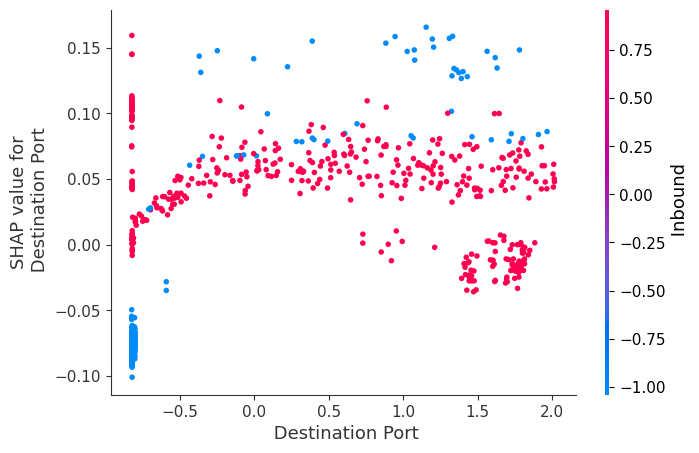

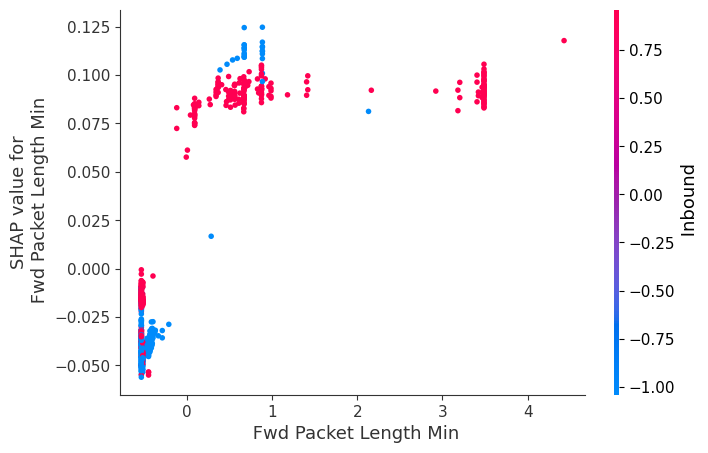

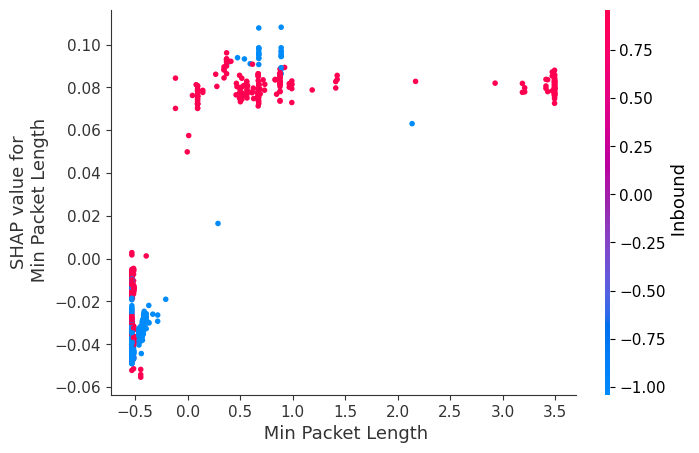

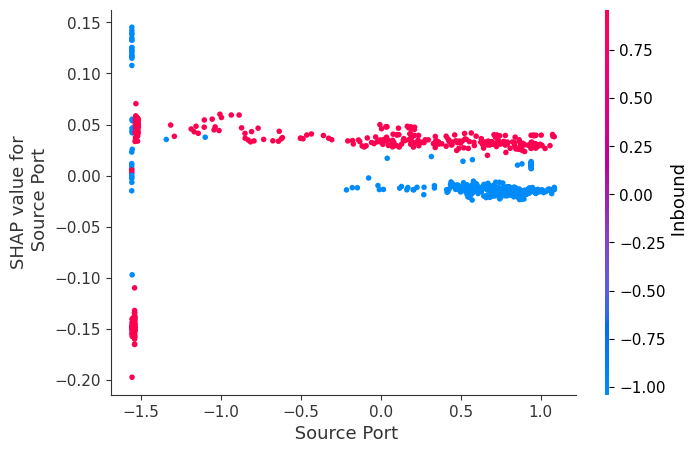

In [29]:
for i in range(5) :
  shap.dependence_plot(f"rank({i})", explanation[:,:,1].values, X_test_new, feature_names=X_test_new.columns)